# Regression analysis in distributed computing 


First thing to note is that with big amounts of data closed form solution through normal equations is not feasible anymore:

$$\mathbf{w} = (X^T X)^{-1} X^T y$$

Computing $X^T X$ term takes $O(nk^2)$ operations, while inverse takes $O(k^3)$, where $n$ is number of observations and $k$ is number of variables. Storage is also considerable, $O(k^2)$ for these matrices and $O(nk)$ for matrix $X$.

How can we deal with these issues? Depends on the type of the problem we have.  

1. **Few variables, but many observations**. Storing $X$ can be solved by distributed form of storage, while computing $X^T X$ matrix can be done through a sum of outer products instead of computing inner products. Outer products work great as we can do them separately on each node and then sum them together in the main node. This is feasible if number of dimensions is not that big, in such case matrices of size $k^2$ should be able to fit on a single node.  
2. **Many variables, and many observations**. Outer product operation is now also not feasible as matrices of size $k^2$ do not fit in any single node. In these situations we can potentially exploit sparsity to reduce the storage and computational requirements. We can also try to reduce the dimensionality through unsupervised learning techniques, such as SVD or PCA. However, the way out is really to discard the closed form approach and use numerical optimization - (stochastic) gradient descent needs less operations, $O(nk)$, and uses far less storage, $O(k)$.


# Logistic regression

Now we will examine how we can use a chain map-reduce operations to train the logistic regression with gradient descent. We will use the Bank marketing dataset from the [UCI repository](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing) to illustrate these operations. It is not a big dataset but it will serve to illustrate the principles. We could have worked with bigger datasets, but it would have involved a lot of waiting for some of the steps.


Outline: 

1. Create an RDD out of the text file 
2. Parse text lines into variables  
3. Normalize variables
4. Create training, validation and test set
5. Baseline model 
6. Logistic regression through gradient descent  
7. Logistic regression through the MLlib Spark library


## 1. Creating an RDD and first look at the data

I provided you with the dataset in a csv format, use that one instead of original dataset from the repository. I only removed the categorical variables. These need special processing operations that we will not cover. You should load the file directly from your bucket and convert it to the RDD using the appropriate function. You should have created a bucket already on S3 and uploaded the dataset there. 

Following the instructions in the comments, fill in the parts in the code below instead of (YOUR_CODE) parts.

In [2]:
# number of workers you have started
numPartitions = 3


# we are loading the text file directly from our bucket and converting it to RDD
# use appropriate function and set the number of partitions
rdd = sc.textFile("s3://sparkuh/data/bank.csv", numPartitions)
type(rdd)

pyspark.rdd.RDD

In [3]:
# use appropriate function to count the number of observations in the dataset
noObs = rdd.count()
print noObs

# use appropriate function to get only 3 observations from the whole dataset
noObservations = 3
fewObs = rdd.take(noObservations)
print fewObs

41188
[u'0,56,261,4.857,5191,0,1.1,93.994,-36.4', u'0,57,149,4.857,5191,0,1.1,93.994,-36.4', u'0,37,226,4.857,5191,0,1.1,93.994,-36.4']


In [4]:
# checking if you got a correct result, you should have 11 million observations
# you will see an output here only if you made an error
assert noObs == 41188, "Something is wrong here!"
assert len(fewObs) == noObservations, "You did not extract correct number of observations"



## 2. Parsing the text lines

From the print of `fewObs` object you should realize that each observation in the current RDD is one long line of text, and not nice a data frame. 

One line should look something like this: 

`u'1,8.692932128906250000e-01,-6.350818276405334473e-01,2.256902605295181274e-01,...'`. 

First point is a label, either a 0 or 1, and remaining numbers are features.

Your first task is to parse the text lines and create variables out of them. We will convert them to a special class `LabeledPoint` from MLlib library (see official docs [here](http://spark.apache.org/docs/latest/mllib-data-types.html)). This is the format used for storing supervised learning data in MLlib, both classification and regression. 

You will fill out the details of the `parseTextLine` function that processes one line of text and returns a LabeledPoint object. You will check it out on couple of observations that you extracted above, on `fewObs` object.

In [5]:
# numpy version should be at least 1.4 for MLlib, there is a ridiculous bug that raises an exception
# because recent numpy is named 1.10 which is mathematically not higher than 1.4
# the bootstrap script installs previous version, 1.9.2 for this reason
import numpy as np
print np.__version__

1.9.2


In [6]:
from pyspark.mllib.regression import LabeledPoint
import numpy as np

# you should fill out details of function parseTextLine
# input: line, a single observation consisting of a string
# output: LabeledPoint instance, text converted to distinct variables, label and features
# use Python's split() method to separate elements of the text lines
def parseTextLine(line):
    attributes = line.split(",")
    label = attributes[0]
    features = attributes[1:len(attributes)]
    return LabeledPoint(label,features)

# check if it works on fewObs object by applying parseTextLine(), the result should be a list
parsedLines = [parseTextLine(line) for line in fewObs]
print type(parsedLines)

# now, print out the features and label separately for the first observation, 
# using the LabeledPoint.features and LabeledPoint.label attributes
print parsedLines[1].features
print parsedLines[1].label


<type 'list'>
[57.0,149.0,4.857,5191.0,0.0,1.1,93.994,-36.4]
0.0


In [7]:
assert len(parsedLines[1].features) == 8, 'You should have 8 features!'

If everything seems to be in order, proceed by parsing all the data.

In [8]:
# use your parseTextLine function on every observation
parsedRDD = rdd.map(parseTextLine)


## 3. Normalizing the features 

Standardizing or normalizing features is very relevant for algorithms using distance measures. In our situation it will also bring significant improvements since we will use (stochastic) gradient descent to train the logistic regression. We will use a simple transformation to 0-1 interval

$$ x_{norm} = (x-min(x)) / (max(x)-min(x)) $$


In [9]:
# take a single row and compute the number of features in it
noFeatures = len(parsedLines[1].features)
print noFeatures  # you should get 8

8


In [10]:
# get min and max for each feature 
featuresMin = []; featuresMax = []
for i in range(noFeatures):
    print i
    feature = parsedRDD.map(lambda lp: lp.features[i])
    featuresMin.append(feature.min())
    featuresMax.append(feature.max())

# print out minimum and maximum value of each feature
print featuresMin
print featuresMax


0
1
2
3
4
5
6
7
[17.0, 0.0, 0.63400000000000001, 4963.6000000000004, 0.0, -3.3999999999999999, 92.200999999999993, -50.799999999999997]
[98.0, 4918.0, 5.0449999999999999, 5228.1000000000004, 7.0, 1.3999999999999999, 94.766999999999996, -26.899999999999999]


In [11]:
# define a function for normalizing each feature according to min and max information
# input: lp, LabeledPoint, a single observation
#        featuresMin, a list of minimum values for each fature
#        featureMax, a list of maximum values for each feature
# output: a LabeledPoint with original label, but new, transformed features
def normalize(lp, featuresMin, featuresMax):
    feat = range(noFeatures)
    for column in range(noFeatures):
        feat[column] = (lp.features[column] - featuresMin[column])/(featuresMax[column]-featuresMin[column])
    return LabeledPoint(lp.label, feat)

# run normalize() on all observations
normedRDD = parsedRDD.map(lambda x: normalize(x, featuresMin, featuresMax)) 

# if everything went all right, you should see 0 and 1 as a result here
print normedRDD.map(lambda lp: lp.features[0]).min()
print normedRDD.map(lambda lp: lp.features[0]).max()

0.0
1.0




## 4. Creating training, validation and test data

Now that we have created proper dataset we will create separate training, validation and test data. You should use the [randomSplit method](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.randomSplit) to randomly create three separate datasets, use the weights and seed supplied below. 


In [12]:
# do not change the weights and the seed
weights = [.7, .15, .15]
seed = 1111

# use randomSplit with weights and seed defined above on the trainRDD
trainRDD, valRDD, testRDD = normedRDD.randomSplit(weights, seed)

Now you should [cache](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.cache) all three of new RDD's, as you will be using them a lot in the remainder of the problem set.

In [13]:
# cache the data
trainRDD.cache()
valRDD.cache()
testRDD.cache()

# get the number of observation in each subset
noTrain = trainRDD.count()
noVal = valRDD.count()
noTest = testRDD.count()

print "Training: {0:.3f}, Validation: {1:.3f}, Test: {2:.3f}, All: {3:.3f}".format(noTrain, noVal, noTest, noTrain + noVal + noTest)


Training: 28927.000, Validation: 6158.000, Test: 6103.000, All: 41188.000


In [14]:
assert noTrain == 28910, "Wrong number of observations. Did you change the weights?"
assert noVal == 6093, "Wrong number of observations. Did you change the weights?"
assert noTest == 6185, "Wrong number of observations. Did you change the weights?"

AssertionError: Wrong number of observations. Did you change the weights?



## 4. Baseline model

For every analysis you should have a good benchmark or baseline as evaluating performance of models is difficult without a reference frame. How do you know whether an accuracy of 75% is a good performance or a bad performance?  

A simplest reference frame is how well could you do with no learning what so ever, that is, without extracting any information from features. In classification problem that we have here, this is a simple proportion of labels in the dataset. In prediction terms, based on this model we will always make the same prediction independent of the features - our average label is the constant prediction value.  If our model is doing worse than this, we are doing something very wrong. 

In [15]:
# compute mean over label part of LabeledPoints
meanLabel=trainRDD.map(lambda x: x.label).mean()

print meanLabel

0.113112317212


In [16]:
assert np.allclose(meanLabel, 0.1106537530266346), "Something is wrong, check your calculation of the mean label"

AssertionError: Something is wrong, check your calculation of the mean label

You should have obtained lower proportion of successful calls than 0.5, hence the prediction of the baseline model for each observation is 0. 

How does the baseline model performs? We will use a misclassification error as a measure of performance. You will now write a function that evaluates the accuracy of each prediction.

In [17]:
def classify(probability, threshold):
    # you can ignore the ties
    if probability > threshold:
        return 1
    else:
        return 0

# this function should compute the misclassification error for a single observation and its prediction,
# you should use classify function to convert probability into predicted labels
# input: probability, float between 0 and 1
#        predictedLabel, float, either 0 or 1, 
#        threshold, float, for classifying predicted probability as 0 or 1
# output: float, 0 if correct and 1 if incorrect
def misErrorSingle(probability, label, threshold):
    prediction = classify(probability, threshold)
    if prediction == label:
        return 0
    else:
        return 1

# this function should compute mean misclassification error on RDD labPred (see example below)
# it should apply the function misErrorSingle on the whole RDD
# input: labPredRDD, a label prediction tuples
#        threshold, float, for classifying predicted probability as 0 or 1
# output: mean misclassification error
def misError(labPredRDD, threshold):
    output = labPredRDD.map(lambda x: misErrorSingle(x[0], x[1], threshold)).mean()
    return output

# check it on an easy example, 1 observation misclassified, 2 correct
labPredRDD_ex = sc.parallelize([(0., 1.), (0., 0.), (1., 1.)])
threshold = 0.5
misError_ex = misError(labPredRDD_ex, threshold)
print misError_ex

0.333333333333


In [18]:
assert np.allclose(misError_ex, 0.333333333333), 'incorrect value for misError_ex'

You should now make predictions based on the baseline model for all three datasets. 

In [19]:
# set the threshold for evaluating the probabiliteis
threshold = 0.5

# for each dataset first create RDD's of tuples with meanLabel and label in each tuple   
# and then feed these RDD's into misError function
baseTrain = trainRDD.map(lambda x: (meanLabel, x.label))
baseTrain_misError = misError(baseTrain, threshold)

baseVal = valRDD.map(lambda x: (meanLabel, x.label))
baseVal_misError = misError(baseVal, threshold)

baseTest = testRDD.map(lambda x: (meanLabel, x.label))
baseTest_misError = misError(baseTest, threshold)

print 'Baseline model - Train misclassification error = {0:.3f}'.format(baseTrain_misError)
print 'Baseline model - Validation misclassification error = {0:.3f}'.format(baseVal_misError)
print 'Baseline model - Test misclassification error = {0:.3f}'.format(baseTest_misError)

Baseline model - Train misclassification error = 0.113
Baseline model - Validation misclassification error = 0.115
Baseline model - Test misclassification error = 0.108



## 5. Training logistic regression with Gradient descent

Now let's see how much better we can do with a simple logistic regression. We will train it with the gradient descent method since analytical solutions require too much storage and computing time. 

Recall from the first term the equation for the gradient descent update for logistic regression: 

$$ \mathbf{w}_{i+1} = \mathbf{w}_i - \alpha \sum_n (\mathbf{w}_i^\top\mathbf{x}_n  - y_n) \mathbf{x}_n \,.$$ 

where $i$ is the iteration number, and $n$ denotes observation. We will use constant learning rate, but there are various schemes for decreasing learning rates, such as $\alpha=\frac{constant}{n\sqrt{i}}$.

Although this is computationally and storage wise much cheaper than analytical solution, there are disadvantages as well. Gradient part is computed in each node and sent to the driver (map step), after sum of gradients is computed in the driver (reduce step), updated weights $\mathbf{w}_{i+1}$ have to be redistributed over the network to all the nodes for the next iteration. Hence, there will be a lot of communication over network.  

In [20]:
from pyspark.mllib.linalg import DenseVector


You will first define a log loss function. Misclassification error that we defined above is great for getting a sense of absolute performance of the algorithm, however it is too rough to use it for monitoring the gradient descent process. You will first define function `logLossSingle` that computes the loss for a single observation, and then function `logLoss` that will implement it in parallel on whole RDD.

Given independent observations likelihood function for binary classification problems can be defined as

$$ L(\theta) = \prod_{i=1}^N p(y_i|x_i\theta) = \prod_{i=1}^N (p_i)^{y_i} (1-p_i))^{1-y_i}$$

Since we would be computing very small numbers we would quickly run into problems with numerical precisions. Hence we actually compute a log of this expression, which is a monotonic transformation and no information is lost

$$ logL(\theta) = - \sum_{i=1}^N y_i log(p_i) + (1-y_i)(1-p_i) $$

To convert it into a minimization problem we multiply it additionally with -1.

In [21]:
from math import log

# input: prob, float, value between 0 and 1, predicted probability that label=1
#        lab, float, label of the observation, either 0 or 1
# output: float, negative log likelihood of a single observation
def logLossSingle(prob, lab):
    
    # if probability is too small/large add/subtract this epsilon value
    # this is because log(0) is not defined
    epsilon = 10e-12
    if np.isclose(prob,0.0):
        prob += epsilon
    elif np.isclose(prob,1.0):
        prob = prob - epsilon

    return -(lab * log(prob) + (1-lab) * log(1-prob))

# if you get an error on any of these check your computations, especially epsilon
print logLossSingle(.5, 1)   # 0.69314718056
print logLossSingle(.99, 1)  # 0.0100503358535
print logLossSingle(.01, 1)  # 4.60517018599
print logLossSingle(0, 1)    # 25.3284360229
print logLossSingle(1, 1)    # 1.00000008275e-11


0.69314718056
0.0100503358535
4.60517018599
25.3284360229
1.00000008275e-11


In [22]:
# logLoss function should compute the mean log loss on the whole RDD probLab 
# input: probLab, RDD of probability label tuples
# output: float, mean log loss
def logLoss(probLab):
    # apply the function logLossSingle on the whole RDD and compute the mean
    output = probLab.map(lambda x: logLossSingle(x[0],x[1])).mean()
    return output

# check it on an easy example
probLabRDD_ex = sc.parallelize([(0.5, 1.), (0.99, 0.), (0.01, 1.)])
logLoss_ex = logLoss(probLabRDD_ex)
print logLoss_ex

3.30116251751


In [23]:
assert np.allclose(logLoss_ex, 3.30116251751), 'Check your logLoss function'


Now define a sigmoid function that will be transforming linear combinations of feature values and weights to probabilities

$$ f(z) = \frac{1}{1+exp(-z)} $$


In [24]:
import math
# define sigmoid function
# input: z, a float, result of a dot product between weights and feature values
# output: a float, dot product transformed to 0-1 range
def sigmoid(z):
    return (1 / (1 + math.exp(-z)))

print sigmoid(0)  # should produce 0.5
print sigmoid(100)  # should produce number close to 1
print sigmoid(-100)  # should produce number close to 0

0.5
1.0
3.72007597602e-44



We will break down the gradient descent algorithm into components. We will write a function for the part that is computed on separate nodes in parallel - gradient. Then these gradients are summed in the driver node and weights are updated based on the whole sum.

Define a function that computes the gradient for a single observation 

$$ (y-f(\mathbf{w}^\top \mathbf{x})) \mathbf{x}$$. 

Pay particular care that your gradient computation is correct. Error in gradients is the most frequent reason why something goes wrong with gradient descent.

You will use the `DenseVector` [dot](http://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.linalg.DenseVector.dot) method to compute a cross product between feature vector and weight vector. I provided you with an example on which you can test it.


In [25]:
# compute the gradient for a single observation
# inputs: weights, an array of regression coefficients; 
#         lp, a LabeledPoint of a single observation
# output: DenseVector, an array of values, same length as weights
def gradient(weights, lp):
    cp = weights.dot(lp.features)
    return (lp.label - sigmoid(cp)) * lp.features

weights_ex = DenseVector([1, 2, 3, 4, 5])
lp_ex = LabeledPoint(1.0, [1, 1, 1, 1, 1])
gradient_ex = gradient(weights_ex, lp_ex)
print gradient_ex
# you should see a following vector: 
# [3.05902226994e-07,3.05902226994e-07,3.05902226994e-07,3.05902226994e-07,3.05902226994e-07]
# sigmoid should produce smth close to 1 so when it is subtracted from 1 we get smth close to 0

[3.05902226994e-07,3.05902226994e-07,3.05902226994e-07,3.05902226994e-07,3.05902226994e-07]



Now you should define a function that creates (probability, label) tuples that we will feed into logLoss() function to keep track of the loss function while we are training the algorithm via gradient descent. Keeping track of what is going on with the loss is one of the diagnostic tools you should always make use of to verify that gradient descent is converging.

Use again the `dot` method to compute the prediction based on vector of weights and feature part of the observation.


In [26]:
# function should operate on a single observation
# input: weights, a numpy array, and lp, a LabeledPoint
# output: a tuple consisting of a predicted probability and a label
def probLabTuple(weights, lp):
    cp = weights.dot(lp.features)
    sig = sigmoid(cp)
    return (sig, lp.label)

# lets check it on an easy example
weights_ex = np.array([1, 2, 3, 4, 5])
data_ex = sc.parallelize([LabeledPoint(1, np.array([-1, -1, -1, 1, 1])),
                          LabeledPoint(0, np.array([-2, 2, -2, -2, 2]))])
probLab_ex = data_ex.map(lambda lp: probLabTuple(weights_ex, lp))
print probLab_ex.collect()
# you should see a list of tuples: [(0.9525741268224334, 1.0), (0.11920292202211755, 0.0)]

# what log loss this produces? you should see the following result: 0.0877576813084
print logLoss(probLab_ex)

[(0.9525741268224334, 1.0), (0.11920292202211755, 0.0)]
0.0877576813084



Now you are ready to define a gradient descent function. There is also a small sample on which you can test it out. 

Use the subset of the data also to determine the best learning rate `alpha`. Try out several values, too big learning rate will lead to increase of loss, for big ones it will appear flat or very erratic, while for appropriate rate the loss will generally decrease and flatten out after enough iterations. Too small rates will work fine but will require more iterations. 

How many iterations should you leave it run? That's difficult to say, it depends on application, you could monitor cost and after it flattened out you can stop. Better indicator is to actually compute the validation error.


In [27]:
# function that performs the gradient descent on a given RDD 
# inputs: dataRDD, rdd with LabeledPoint observations, 
#         noIter, integer defining number of iterations
#         alpha, float, learning rate
#         diagnostics, bool, should the error be recorded?
# output: a tuple consisting of two numpy arrays, one will be final weights, 
#         the other loss in each iteration
def gradientDescent(dataRDD, noIter, alpha, diagnostics):
    
    # some help variables and arrays for storing the results
    noObs = dataRDD.count()
    noFeatures = len(dataRDD.take(1)[0].features)
    error = np.zeros(noIter)  # we will keep track of misclassification error with each iteration
    weights = np.zeros(noFeatures)  # initialize weights to zero's
    
    # we iterate until convergence, or in our case, defined by fixed number of iterations
    for i in range(noIter):

        # we will also keep track of the loss, compute the loss here with the current weights
        # use probLabTuple() function defined above and apply it on whole dataRDD
        if diagnostics:
            probLab = dataRDD.map(lambda x: probLabTuple(weights,x))
            error[i] = logLoss(probLab)
        
        # compute mean gradient (computed in the driver node)
        # use the gradient() function you defined earlier
        # meanGradient should be a DenseVector and have same number of features as weights vector
        meanGradient = dataRDD.map(lambda x: gradient(weights,x)).mean()
        weights += alpha*meanGradient # we update the weights based on the totalGradient
    
    if diagnostics:
        return weights, error
    else:
        return weights


# ----
# Check it on a smaller subset of data
# ----

# subset of the data
data_ex = (sc
            .parallelize(trainRDD.take(300))
            .map(lambda lp: LabeledPoint(lp.label, lp.features)))
print data_ex.take(2)

# set the parameters, you can use a smaller subset to verify the learning rate
# try other alpha values 76, 36, 26, 6, 0.6
alpha = 6
noIter = 100
diagnostics = True

# run the GD
weights_ex, error_ex = gradientDescent(data_ex, noIter, alpha, diagnostics)
print "weights\n", weights_ex
print "Log loss\n", error_ex

[LabeledPoint(0.0, [0.481481481481,0.0530703538024,0.957379279075,0.859735349716,0.0,0.9375,0.698752922837,0.602510460251]), LabeledPoint(0.0, [0.493827160494,0.0302968686458,0.957379279075,0.859735349716,0.0,0.9375,0.698752922837,0.602510460251])]
weights
[-0.76029627  1.91540029 -1.01658687 -0.91290431  0.         -0.99547819
 -0.74196618 -0.63977176]
Log loss
[ 0.69314718  0.23321951  0.22179446  0.21040121  0.19905954  0.18780132
  0.17667743  0.16576806  0.15519683  0.1451477   0.13587869  0.12771741
  0.12101238  0.11601905  0.11275129  0.11091461  0.11002525  0.10963315
  0.10945271  0.10934863  0.10926914  0.10919703  0.10912708  0.10905777
  0.10898868  0.10891968  0.10885075  0.10878187  0.10871305  0.10864428
  0.10857556  0.10850689  0.10843828  0.10836972  0.10830121  0.10823276
  0.10816436  0.10809601  0.10802772  0.10795948  0.10789129  0.10782315
  0.10775507  0.10768705  0.10761908  0.10755116  0.10748329  0.10741548
  0.10734773  0.10728002  0.10721238  0.10714478  0


Now lets check how the loss is behaving in each iteration. If loss is not decreasing over time, you should try other learning rates, and if you don't get any improvements, something might be wrong with your gradient function.

Note that we computed the loss over whole dataset. This works on a smaller subset when you are trying to set the learning rate, with the whole dataset (if it is a big one) this might take too much time and you should turn off that computation. If you use stochastic gradient descent instead, you can compute loss of the same observation or batch of observations that are used in the stochastic gradient descent (this is a small extension of the current gradientDescent function where the weight vector is updated after processing each observation or a small batch of randomly chosen observations). 


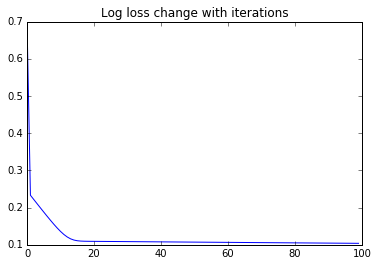

In [28]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# do some diagnostics
x = range(0, len(error_ex))
plt.plot(x, error_ex)
plt.title('Log loss change with iterations')
plt.show()


### Apply gradient descent on whole dataset

Now let's train the logistic regression model on all of our training data and evaluate its accuracy on the validation set. You would most likely need many more iterations than 500 to get better estimates.

With the dataset of this size gradient descent works fine and you can easily run 10000 iterations on this dataset. However, on big datasets you would use stochastic version. We will not implement it, instead, now that you understand much better map-reduce operations that are going on under the hood, go to the next section and use MLlib function for training the logistic regression. That function uses stochastic gradient descent and provides you with several other useful options.

In [ ]:
# set the parameters, setting diagnostics to True will increase the time 
# with 14 workers this took about 5 min
alpha = 6
noIter = 500
diagnostics = False


# run the gradient descent on whole training set
count = trainRDD.count()

weights_gd = gradientDescent(normedRDD, noIter, alpha, diagnostics)
print "weights\n", weights_gd


In [315]:
# threshold parameter for misclassification
threshold = 0.5

# compute the log loss and missclassification error on training 
probLabTrain = trainRDD.map(lambda x: probLabTuple(weights_gd, x))
logLossTrain_gd = logLoss(probLabTrain)
misErrorTrain_gd = misError(probLabTrain, threshold)

print logLossTrain_gd, misErrorTrain_gd

# and validation set
probLabVal = valRDD.map(lambda x: probLabTuple(weights_gd,x))
logLossVal_gd = logLoss(probLabVal)
misErrorVal_gd = misError(probLabVal, threshold)

print logLossVal_gd, misErrorVal_gd

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 5079.0 failed 4 times, most recent failure: Lost task 0.3 in stage 5079.0 (TID 13410, ip-172-31-14-76.eu-west-1.compute.internal): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/home/hadoop/spark/python/pyspark/worker.py", line 101, in main
    process()
  File "/home/hadoop/spark/python/pyspark/worker.py", line 96, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/home/hadoop/spark/python/pyspark/rdd.py", line 2252, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/home/hadoop/spark/python/pyspark/rdd.py", line 2252, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/home/hadoop/spark/python/pyspark/rdd.py", line 282, in func
    return f(iterator)
  File "/home/hadoop/spark/python/pyspark/rdd.py", line 942, in <lambda>
    return self.mapPartitions(lambda i: [StatCounter(i)]).reduce(redFunc)
  File "/home/hadoop/spark/python/pyspark/statcounter.py", line 40, in __init__
    for v in values:
  File "<ipython-input-315-5b794c7633a3>", line 5, in <lambda>
NameError: global name 'weights_gd' is not defined

	at org.apache.spark.api.python.PythonRDD$$anon$1.read(PythonRDD.scala:135)
	at org.apache.spark.api.python.PythonRDD$$anon$1.<init>(PythonRDD.scala:176)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:94)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:277)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:244)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:61)
	at org.apache.spark.scheduler.Task.run(Task.scala:64)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:203)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1145)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:615)
	at java.lang.Thread.run(Thread.java:745)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1204)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1193)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1192)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:47)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1192)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:693)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:693)
	at scala.Option.foreach(Option.scala:236)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:693)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1393)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1354)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)


In [310]:
# compare it with the logLoss of the baseline model
# training set
probLabTrain = trainRDD.map(lambda x: (meanLabel, x.label))
logLossTrain_base = logLoss(probLabTrain)

print logLossTrain_base, baseTrain_misError

# validation set
probLabVal = valRDD.map(lambda x: (meanLabel, x.label))
logLossVal_base = logLoss(probLabVal)

print logLossVal_base, baseVal_misError

0.347879986213 0.110653753027
0.360462689972 0.116691285081



## 6. Logistic regression with MLlib

We will now use [LogisticRegressionWithSGD](https://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.classification.LogisticRegressionWithSGD) function from the MLlib Spark library. It returns a [LogisticRegressionModel](https://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.regression.LogisticRegressionModel) with plenty of useful methods.  You can access the weight by using the `LogisticRegressionModel.weights` attributes.


In [309]:
from pyspark.mllib.classification import LogisticRegressionWithSGD

# set parameters
noIter = 500
alpha = 60  # MLlib algorithm uses decaying learning rate, so we need to increase it
batchSize = 0.003  # defined as proportion of the whole dataset, ~100 observations
regLambda = 1e-6
regType = 'l2'
intercept = False

False


In [316]:
# training the model on trainRDD
model_sgd = (LogisticRegressionWithSGD.train(data=trainRDD, iterations=noIter, 
                                             step=alpha,miniBatchFraction=batchSize,
                                             regType=regType,intercept=intercept, regParam=regLambda))

KeyboardInterrupt: 

In [ ]:
# check the weights
weights_sgd = model_sgd.weights
print weights_sgd

In [ ]:
# evaluate the model

# create probLabRDD and compute the log loss and missclassification error on training, using the new SGD weights
probLabTrain = trainRDD.map(lambda lp: probLabTuple(weights_sgd, lp))
logLossTrain_sgd = logLoss(probLabTrain)
misErrorTrain_sgd = misError(probLabTrain, threshold)

print logLossTrain_sgd, misErrorTrain_sgd

# for validation set, using the new SGD weights
probLabVal = valRDD.map(lambda lp: probLabTuple(weights_sgd, lp))
logLossVal_sgd = logLoss(probLabVal)
misErrorVal_sgd = misError(probLabVal, threshold)

print logLossVal_sgd, misErrorVal_sgd

### Optimizing the hyperparameters

Do a grid search to find a good regularization parameter lambda and good learning rate.  
Try `regLambda` values [1e-6, 1e-3, 1] and alpha values [0.1, 1, 10, 50, 100].


In [ ]:
noIter = 500
batchSize = 0.003  # defined as proportion of the whole dataset, ~100 observations
regType = 'l2'
intercept = False
modelLoss = []  # storing losses of each model

for alpha in [0.1, 1, 10, 50, 100]:
    for regLambda in [1e-6, 1e-3, 1]:
        model = ( LogisticRegressionWithSGD.train(data=trainRDD, iterations=noIter, step=alpha,miniBatchFraction=batchSize,regType=regType,intercept=intercept)) )
        
        # evaluate the model
        probLabVal = valRDD.map(lambda x: probLabTuple(weights_sg,x))
        logLossVal = logLoss(probLabVal)
        modelLoss.append(logLossVal)
        
        # some printout in each iteration
        print 'alpha = {0:.0e}, lambda = {1}, loss = {2:.3f}'.format(alpha, regLambda, logLossVal)


Lambda of 1 and alpha of 50 seems to be a good solution. Lets use it for final evaluation.

In [ ]:
# set parameters
noIter = 500
alpha = 50  
batchSize = 0.003  
regLambda = 1
regType = 'l2'
intercept = False

# train it on trainRDD
theModel = (LogisticRegressionWithSGD.train(data=trainRDD, iterations=noIter, 
                                            step=alpha,miniBatchFraction=batchSize,
                                            regType=regType,intercept=intercept, regParam=regLambda)) 

In [ ]:
# evaluate the final model

# create probLabRDD and compute the log loss and missclassification error on training, using the new SGD weights
probLabTrain = trainRDD.map(lambda lp: probLabTuple(theModel.weights, lp))
logLossTrain_sgd = logLoss(probLabTrain)
misErrorTrain_sgd = misError(probLabTrain, threshold)

print logLossTrain_sgd, misErrorTrain_sgd

# for validation set, using the new SGD weights
probLabVal = valRDD.map(lambda lp: probLabTuple(theModel.weights, lp))
logLossVal_sgd = logLoss(probLabVal)
misErrorVal_sgd = misError(probLabVal, threshold)

print logLossVal_sgd, misErrorVal_sgd

In [ ]:
# finally, assesing our final chosen model on the test set
probLabTest = testRDD.map(lambda lp: probLabTuple(theModel.weights, lp))
logLossTest_sgd = logLoss(probLabTest)
misErrorTest_sgd = misError(probLabTest, threshold)

print logLossTest_sgd, misErrorTest_sgd